In [1]:
#import modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.stats import zscore
import sklearn
from sklearn.model_selection import train_test_split
import fnmatch

In [2]:
#functions for read in data

def find_files(directory, pattern='Data*.csv', withlabel=True):
    '''fine all the files in one directory and assign '1'/'0' to F or N files'''
    files = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            if withlabel:
                if 'non-seizure' in filename:
                    label = '0'
                else:
                    label = '1'
                files.append((os.path.join(root, filename), label))
            else:  # only get names
                files.append(os.path.join(root, filename))
    
    return files

def read_data(filename, header=None, ifnorm=False):
    '''read data from .csv
    Param:
        filename: string e.g. 'data/Data_F_Ind0001.csv'
        ifnorm: boolean, 1 zscore normalization
        start: with filter augmented data, start index of the column indicate which group of data to use
        width: how many columns of data to use, times of 2
    return:
        data: 2d array [seq_len, channel]'''

    data = pd.read_csv(filename, header=header, nrows=None)
    data = data.values  ### get data without row_index
    if ifnorm:   ### 2 * 10240  normalize the data into [0.0, 1.0]]
        data_norm = zscore(data)
        data = data_norm
    #data = np.squeeze(data)   ## shape from [1, seq_len] --> [seq_len,]
    return data


In [3]:
#find segmented files and return them with label
seg_files_wlabel = find_files('C:\\Users\\hien\\Desktop\\eeg_data\\seg_data', pattern='seg*.csv', withlabel=True)

print("first file with label:", seg_files_wlabel[0])

first file with label: ('C:\\Users\\hien\\Desktop\\eeg_data\\seg_data\\segNorm_read_out_annosep09_anno_115_non-seizure_No0.csv', '0')


In [4]:
#split files and labels

files, labels = np.array(seg_files_wlabel)[:, 0].astype(np.str), np.array(np.array(seg_files_wlabel)[:, 1]).astype(np.int)

print("first filename:", files[0])
print("first label", labels[0])

first filename: C:\Users\hien\Desktop\eeg_data\seg_data\segNorm_read_out_annosep09_anno_115_non-seizure_No0.csv
first label 0


In [5]:
#number of elements in files/labels
len(labels)

540

In [6]:
#split data into training and testing

files_train, files_test, labels_train, labels_test = train_test_split(files, labels, test_size=0.4, random_state=42)

#print(labels_train)
print("number of test input:", len(labels_test))
print("number of training input:", len(labels_train))


number of test input: 216
number of training input: 324


In [7]:
#set parameters

learning_rate = 0.001
total_iteration = 30 #number of iterations over all samples / number of epochs
batch_size = 64 #amount of files fed to model per iteration
test_sample = len(labels_test)
total_batches = len(labels_train)//batch_size
num_classes = 2

hidden_dim = 2048
hidden_dim2= 1024
hidden_dim3 = 512
hidden_dim4 = 256
hidden_dim5 = 128
hidden_dim6 = 64

In [162]:
#set variables x=input, y_=output, W=weights, b=bias

x_ori = tf.placeholder("float",[None, 2048, 1], name = "x_ori") #number of data points
y_ = tf.placeholder("float",[None,2], name = "y_") #2 possible outputs

W = tf.Variable(tf.zeros([2048, hidden_dim]), name = "W")
b = tf.Variable(tf.zeros([hidden_dim]), name = "b")

W2 = tf.Variable(tf.zeros([hidden_dim, hidden_dim2]), name = "W2")
b2 = tf.Variable(tf.zeros([hidden_dim2]), name = "b2")

W3 = tf.Variable(tf.zeros([hidden_dim2,hidden_dim3]), name = "W3")
b3 = tf.Variable(tf.zeros([hidden_dim3]), name = "b3")

W4 = tf.Variable(tf.zeros([hidden_dim3,hidden_dim4]), name = "W4")
b4 = tf.Variable(tf.zeros([hidden_dim4]), name = "b4")

W5 = tf.Variable(tf.zeros([hidden_dim4,hidden_dim5]), name = "W5")
b5 = tf.Variable(tf.zeros([hidden_dim5]), name = "b5")

W6 = tf.Variable(tf.zeros([hidden_dim5,hidden_dim6]), name = "W6")
b6 = tf.Variable(tf.zeros([hidden_dim6]), name = "b6")

W7 = tf.Variable(tf.zeros([hidden_dim6,2]), name = "W7")
b7 = tf.Variable(tf.zeros([2]), name = "b7")


In [163]:
#flatten input

x = tf.contrib.layers.flatten(x_ori, outputs_collections=None, scope=None)

In [164]:
#network
#below the set up for the networks. for less hidden layers, set comments

y = tf.nn.relu(tf.matmul(x,W) + b)

In [165]:
y2 = tf.nn.relu(tf.matmul(y,W2) + b2)

In [166]:
drop = tf.nn.dropout(y2, keep_prob = 0.1, noise_shape=None, seed=None, name=None)

In [167]:
y3 = tf.nn.relu(tf.matmul(drop,W3) + b3)

In [168]:
y4 = tf.nn.relu(tf.matmul(y3,W4) + b4)

In [169]:
y5 = tf.nn.relu(tf.matmul(y4,W5) + b5)

In [170]:
y6 = tf.nn.relu(tf.matmul(y5,W6) + b6)

In [171]:
y7 = tf.nn.softmax(tf.matmul(y6,W7) + b7)

In [172]:
network_output = tf.argmax(y7, axis=1) 

In [173]:
#Cost function - difference between the predicted value and the actual value

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(_sentinel=None, labels=y_, logits=y7, dim=-1, name=None)


In [174]:
#Determining accuracy of parameters

predictions = tf.equal(tf.argmax(y7,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))

In [175]:
#Implementing Gradient Descent Algorithm
 
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
loss_op = tf.reduce_mean(cross_entropy)

In [176]:
#rearrange dataset

dataset_train = tf.data.Dataset.from_tensor_slices((files_train, labels_train)).repeat().batch(batch_size).shuffle(buffer_size=10000)
iter = dataset_train.make_initializable_iterator()
ele = iter.get_next()   #you get the filename

In [177]:
tf.set_random_seed(43469)

i: 0 batch: 4 acc 0.53125
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
i: 10 batch: 4 acc 0.53125
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
i: 20 batch: 4 acc 0.53125
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074
acc_test 0.5324074


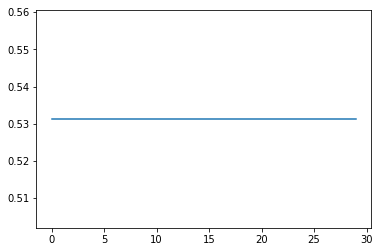

In [178]:
#run session and plot train accuracy

with tf.Session() as sess:
    sess.run(iter.initializer)
    sess.run(tf.global_variables_initializer())
    
    acc_iteration = [] 
    acc_iteration_test = []
    
    for i in range(total_iteration):
        #total_batches = int(mnist.train.num_examples / batch_size)
        
        acc_batch = []
        acc_batch_test = []
        avg_cost = 0
        
        for batch in range(total_batches):
            files_train, labels_train =  sess.run(ele)   # names, 1s/0s the filename is bytes object!!! TODO
            
            data_train = np.zeros([batch_size, 2048, 1])
            files_train = files_train.astype(np.str)
            
            
            #print(files_train[0])
            for ind in range(batch_size):
                #print(files_train)
                data = read_data(files_train[ind],  header=None, ifnorm=True)
                data_train[ind, :] = data
            
            labels_train_hot =  np.eye((num_classes))[labels_train.astype(int)] # get one-hot lable
            
            
            _, pred, acc, c = sess.run([train_op, predictions, accuracy, loss_op], feed_dict={x_ori: data_train, y_: labels_train_hot})
            acc_batch.append(acc)
            avg_cost += c / total_batches
        if i % 10 == 0:
            print('i:', i, 'batch:', batch, 'acc', acc)
            
            
            
        data_test = np.zeros([test_sample, 2048, 1])    
        for test_nr in range(test_sample):
            #data_test = np.zeros([test_sample, 2048, 1])
            files_test = files_test.astype(np.str)
                
            data_test_01 = read_data(files_test[test_nr],  header=None, ifnorm=True)
            data_test[test_nr, :] = data_test_01
            
        labels_test_hot = np.eye((num_classes))[labels_test.astype(int)]
            
        pred_test, acc_test, pred_labels = sess.run([predictions, accuracy, network_output], feed_dict={x_ori: data_test, y_: labels_test_hot})
        acc_batch_test.append(acc_test)
        print('acc_test', acc_test)
        
        aver_acc_batch = np.mean(np.array(acc_batch))
        acc_iteration.append(aver_acc_batch)
        
        aver_acc_batch_test = np.mean(np.array(acc_batch_test))
        acc_iteration_test.append(aver_acc_batch_test)
    
    

            
plt.plot(np.array(acc_iteration))   


In [179]:
avg_cost

0.6913806557655335

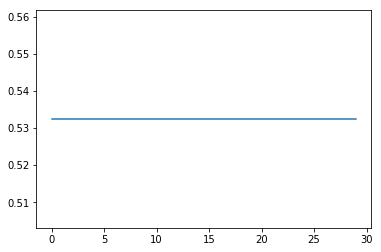

In [180]:
#plot test accuracy

plt.plot(np.array(acc_iteration_test))  

In [181]:
#pred_labels

In [182]:
#labels_test

In [183]:
sklearn.metrics.confusion_matrix(labels_test, pred_labels, labels=None, sample_weight=None)

array([[115,   0],
       [101,   0]], dtype=int64)